# Desagregacion Forecast V3 Mac - Entrenamiento y Ejecucion

In [1]:
import modulo_conn_sql as mcq
import numpy as np
import pandas as pd 
import datetime 
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin

import sqlalchemy as sa
import urllib

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from xgboost import XGBRegressor

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from livelossplot import PlotLossesKeras
import keras.optimizers as opts

from pickle import dump
from pickle import load
from keras.models import load_model

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

#SQL Methods to get operation data
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

# dataset(pandas dataframe): base de datos con el historico
# array_group_top(array) : array de la jerarquia mas ALTA con el nombre de las columnas del dataset por el cual se quiere agrupar las proporciones
# array_group_bottom(array) : array de la jerarquia mas BAJA con el nombre de las columnas del dataset por el cual se quiere agrupar las proporciones
# medida_target( string ) : nombre de la columna que contiene los datos objetivo de la proporcion
# group_target(array) : array de nombre de columnas con las cuales queremos la proporcion final
# name_proportion(string) : etiqueta de la dimension a la cual le estamos calculando la proporcion
    
def historical_proportion( dataset, array_group_top, array_group_bottom, medida_target, group_target, name_proportion  ):

    promedio_group_top = dataset.groupby(array_group_top)[medida_target].mean().reset_index()
    promedio_group_bottom = dataset.groupby(array_group_bottom)[medida_target].mean().reset_index()    
    proportion  = pd.merge(promedio_group_bottom, promedio_group_top, how = 'inner', left_on = array_group_top, right_on = array_group_top )
    proportion['proportion'] = proportion[medida_target + '_x'] / proportion[medida_target + '_y']
    proportion = proportion.groupby(group_target)['proportion'].mean().reset_index()
    proportion.rename(columns={'proportion':'proportion_' + name_proportion}, inplace = True)
    
    return proportion 




Using TensorFlow backend.


# ENTRENAMIENTO

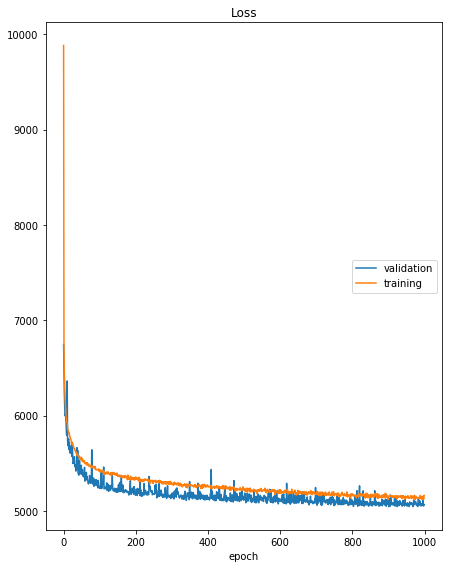

Loss
	validation       	 (min: 5044.793, max: 6745.507, cur: 5066.217)
	training         	 (min: 5117.803, max: 9881.169, cur: 5162.346)


In [31]:
df = pd.read_csv('../datos/df_datatraining.csv')

# declaracion de label encoders
le_planta = preprocessing.LabelEncoder()

# dataframe auxiliar para codificar variables categoricas
df_encoding_1 = df[['Planta']]

#aplicacion del label encoding
df_encoding_1['Planta'] = le_planta.fit_transform(df_encoding_1['Planta'])

# se guardan los label encoders
dump(le_planta, open('../label_encoders_scalers/le_planta.pkl', 'wb'))

# escalamiento de variables numericas
num_vars = ['Año', 'Mes','Semana_Relativa','DiaSemana', 'media1', 'media2', 'media3', 'media6', 'volumen_ciudad']
values_scaled = df[num_vars].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(values_scaled)

#se guarda el escalador
dump(min_max_scaler, open('../label_encoders_scalers/min_max_scaler.pkl', 'wb'))

dataTraining = pd.concat([
    df[['Planta', 'proportion_semana1', 'proportion_semana2', 'proportion_semana3',
       'proportion_semana6', 'proportion_dia_semana1',
       'proportion_dia_semana2', 'proportion_dia_semana3',
       'proportion_dia_semana6', 'PlantaCentral', 'totalEntregado']].reset_index(),
    pd.DataFrame(min_max_scaler.transform(df[num_vars].values), columns = num_vars)], 
    axis = 1, join='inner')

dataTraining['Planta'] = le_planta.transform(dataTraining['Planta'])

dataTraining = dataTraining.drop(['index'], axis = 1)

# separacion variables predicotras y variable de interes
y = dataTraining['totalEntregado']
X = dataTraining.drop(['totalEntregado'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

resultados = []

## ENTRENAR RANDOM FOREST
modelo_rf = RandomForestRegressor(
    bootstrap= True,
    max_depth= None,
    max_features= 1,
    min_samples_leaf= 1,
    min_samples_split= 2,
    n_estimators= 120)

modelo_rf.fit(X_train, y_train)
y_pred = modelo_rf.predict(X_test)

resultados.append({'RandomForest': np.sqrt(metrics.mean_squared_error(y_test, y_pred))} )

# guardar RandomForest
dump(modelo_rf, open('../models/modelo_rf.sav', 'wb'))

## ENTRENAR XGBOOST

modeloXGB = XGBRegressor(
    n_estimators = 400,
    gamma = 0,
    learning_rate = 0.2,
    max_depth = 4,
    colsample_bylevel = 1)

# fit model
modeloXGB.fit(X_train, y_train)

y_pred = modeloXGB.predict(X_test)

resultados.append({'XGBoost': np.sqrt(metrics.mean_squared_error(y_test, y_pred)) } )

# guardar xgboost
dump(modeloXGB, open('../models/modelo_xgb.sav', 'wb'))

X_train = np.array(X_train)
X_test = np.array(X_test)

y_train  = np.array(y_train)
y_test = np.array(y_test)

y_test = np.reshape(y_test,( int(y_test.shape[0]), 1))
y_train = np.reshape(y_train,( int(y_train.shape[0]), 1))

output_var = y_train.shape[1]
dims = X_train.shape[1]

K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()

# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model.add(Dense(4000, input_shape=(dims,),activation='relu'))
model.add(Dropout(0.5))

#model.add(Dense(20, input_shape=(dims,),activation='relu'))


model.add(Dense(output_var))
model.add(Activation('relu'))

# Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento de la red neuronal con n épocas
model.fit(X_train, y_train,
          validation_data = (X_test, y_test),
          epochs=1000, 
          callbacks=[PlotLossesKeras()])

y_pred = model.predict(X_test)
    
resultados.append({'RedNeuronal': np.sqrt(metrics.mean_squared_error(y_test, y_pred)) } )

# guardar red neuronal
model.save('../models/modelo_rn.h5')

In [32]:
resultados

[{'RandomForest': 68.21794798336845},
 {'XGBoost': 67.49815488506623},
 {'RedNeuronal': 71.17736400866451}]

# PREDICCION

In [33]:
datatesting = pd.read_csv('../datos/df_datatesting.csv')
datatesting = datatesting.drop(['Unnamed: 0'], axis = 1)

## aplicacion de label encoding y escalamiento de variables

#Cargar label encoders y escalador
le_planta = load(open('../label_encoders_scalers/le_planta.pkl', 'rb'))
min_max_scaler = load(open('../label_encoders_scalers/min_max_scaler.pkl', 'rb'))

datatesting['Planta'] = le_planta.transform(datatesting['Planta'])
num_vars = ['Año', 'Mes','Semana_Relativa','DiaSemana', 'media1', 'media2', 'media3', 'media6', 'volumen_ciudad']

datatesting_transformed = pd.concat([
    datatesting[['Planta', 'proportion_semana1', 'proportion_semana2', 'proportion_semana3',
       'proportion_semana6', 'proportion_dia_semana1',
       'proportion_dia_semana2', 'proportion_dia_semana3',
       'proportion_dia_semana6', 'PlantaCentral']].reset_index(),
    pd.DataFrame(min_max_scaler.transform(datatesting[num_vars].values), columns = num_vars )
],

axis = 1, 
    join = 'inner')

datatesting_transformed = datatesting_transformed.drop(['index'], axis = 1)

# Cargar los modelos de regresion

m_rf = load(open('../models/modelo_rf.sav', 'rb'))
m_xgb = load(open('../models/modelo_xgb.sav', 'rb'))
m_rn = load_model('../models/modelo_rn.h5')

## MODELO CON RANDOM FOREST
y_pred_RF = m_rf.predict(datatesting_transformed)
df_RF = pd.DataFrame(y_pred_RF)
df_RF.rename(columns={0:'PrediccionRF'}, inplace = True)

## MODELO CON XGBOOST
y_pred_XG = m_xgb.predict(datatesting_transformed)
df_XG = pd.DataFrame(y_pred_XG)
df_XG.rename(columns={0:'PrediccionXG'}, inplace = True)

## MODELO CON REDES NEURONALES

y_pred_RN = m_rn.predict(datatesting_transformed)
df_RN = pd.DataFrame(y_pred_RN)
df_RN.rename(columns={0:'PrediccionRNR'}, inplace = True)

# Se agrega resultados de los modelos y se saca un consenso de IA

result_consejo = pd.concat([ datatesting_transformed, df_RN, df_RF, df_XG ], axis=1, join='inner')
result_consejo['consenso_ia'] = result_consejo[['PrediccionRNR','PrediccionRF','PrediccionXG']].median(axis=1)

# se hace la transformacion inversa de escaladores y label encodings
result_consejo['Planta'] = le_planta.inverse_transform(result_consejo['Planta'])

result_consejo = pd.concat([
    result_consejo[['Planta', 'proportion_semana1', 'proportion_semana2', 'proportion_semana3',
       'proportion_semana6', 'proportion_dia_semana1',
       'proportion_dia_semana2', 'proportion_dia_semana3',
       'proportion_dia_semana6', 'PlantaCentral',
       'PrediccionRNR','PrediccionRF','PrediccionXG', 'consenso_ia']].reset_index(),
    pd.DataFrame(min_max_scaler.inverse_transform(result_consejo[num_vars].values), columns = num_vars )
],

axis = 1, 
    join = 'inner')

result_consejo = result_consejo.drop(['index'], axis = 1)

result_consejo['consenso_ia'] = np.select(
    [result_consejo['DiaSemana'] == 1.0],
    [0], 
    default = result_consejo['consenso_ia'])

result_consejo.to_excel('../datos/resultado_consenso.xlsx')

In [34]:
result_consejo.head()

,Planta,proportion_semana1,proportion_semana2,proportion_semana3,proportion_semana6,proportion_dia_semana1,proportion_dia_semana2,proportion_dia_semana3,proportion_dia_semana6,PlantaCentral,...,consenso_ia,Año,Mes,Semana_Relativa,DiaSemana,media1,media2,media3,media6,volumen_ciudad
0,F001,0.970623,0.918180,0.986367,1.052735,1.005564,0.950691,0.944384,0.966145,1,...,417.677979,2022.0,6.0,1.0,4.0,349.990,345.370000,351.467821,346.542259,970329.15
1,F003,0.940951,1.022711,0.981365,1.061273,0.942191,1.010592,1.018597,1.022724,1,...,231.442551,2022.0,6.0,1.0,4.0,184.875,194.239583,206.736645,218.265682,970329.15
2,F006,0.834696,0.944450,0.956251,1.019247,0.903970,0.964392,0.986881,1.029085,1,...,239.188339,2022.0,6.0,1.0,4.0,220.140,206.825435,204.220162,209.089851,970329.15
3,F007,0.937118,0.888450,0.934905,0.984850,1.055657,1.005466,1.002877,1.023408,1,...,410.019470,2022.0,6.0,1.0,4.0,368.550,352.845652,355.874666,329.766173,970329.15
4,F030,1.047194,1.226465,1.040867,1.053086,0.913792,0.841873,0.923324,1.004300,1,...,177.725388,2022.0,6.0,1.0,4.0,139.460,131.219130,145.094805,175.451916,970329.15
